# Using Integer Linear Programming for Directed Graph Layout
One difficult problem in data visualization is directed graph layout. Directed graph layout techniques have been extensively studied and numerous academic papers have been published on the subject. Some of the popular papers were authored by Sugiyama and Gansner. An old, but still quite popular tool for laying out directed graphs is GraphViz. A newer tool developed by Kiel University is ELK (Eclipse Layout Kernel). There are several variations but the overall concept is to assign the nodes layers such that as many edges as possible are pointing downstream. After the nodes are assigned layers, their positions within the layer are swapped to minimize edge crossings usually by moving them toward nodes they are connected to. All of these techniques are designed to minimize edge length, edge crossings, and backward edges and total graph area.

Directed graphs in this context means that we have a set of nodes and a set of edges that point from one node source to one node destination. Some of these types of graphs also have node ports that edges connect to. Sometimes the port positions have a fixed position on the node, sometimes the ports are movable or swappable. Some of these types of graphs support hyper edges which are edges with zero or more sources and zero or more destinations(instead of one to one). Usually the preferred edge routing method is orthogonal, where the edges can only travel horizontally or vertically. Some implementations alos support bezier curves.

Most of the published techniques for directed graph layout rely on a particular direction of flow (left to right or top to bottom). While some of the tools (like GraphViz) utilizing these techniques support fixed port positions, when ports are on the wrong side of the flow direction, the graph layout can be very poor. Also, some graphs have domain specific conventions for flow direction which makes layered graph techniques more complex to implement properly.

Also, additional structures in the graph such as subgraphs can make the layout algorithms even more complicated.

This notebook demonstrates how we can simplify layout algorithms by formulating our rules mathematically as a set of constraints and a cost function and allowing an off-the-shelf ILP solver to efficiently find the optimal solution. It also demonstrates a layout that doesn't have a single flow direction. The edge port sides define the direction of each edge.

In this example, we will by using Google's ortools constraint solver, but the process is pretty similar for most solvers.

In [ ]:
# python3 built-in
from collections import namedtuple
import xml.etree.ElementTree as ET
from enum import Enum

# 3rd party dependencies
from IPython.display import SVG, display
from ortools.constraint_solver import pywrapcp

Here we define some simple objects to encode our information. We use `Position` both for logical position (grid positioning) as well as visualization position (svg drawing units). We use `Dimension` for widths and heights. We use `Side` for defining which side of the node a port is locked to.

In [2]:
# both of these are two integers
Position = namedtuple("Position", "x y")
Dimension = namedtuple("Dim", "width height")

# defines which side of a node an edge should connect to
class Side(Enum):
    TOP = 1
    BOTTOM = 2
    LEFT = 3
    RIGHT = 4

Here we define an example data set of a handful of nodes and edges between them.

In [3]:
# node positions must be within the domain
domain = Dimension(5, 5)
# enumerate some nodes
nodes = {
    'A':{'ports':[{'side':Side.RIGHT},{'side':Side.BOTTOM}]},
    'B':{'ports':[{'side':Side.TOP },{'side':Side.RIGHT}]},
    'C':{'ports':[{'side':Side.LEFT}]},
    'D':{'ports':[{'side':Side.LEFT}]},
    'E':{'ports':[{'side':Side.RIGHT}]}
}

# enumerate some edges
edges = [
    {'source_node':'A', 'source_port_index':0, 'dest_node':'B', 'dest_port_index':0},
    {'source_node':'A', 'source_port_index':1, 'dest_node':'C', 'dest_port_index':0},
    {'source_node':'B', 'source_port_index':1, 'dest_node':'D', 'dest_port_index':0},
    {'source_node':'E', 'source_port_index':0, 'dest_node':'A', 'dest_port_index':1},
    {'source_node':'A', 'source_port_index':0, 'dest_node':'D', 'dest_port_index':0}
]

If the input dataset has edges following ports into a cycle, then we can tag edges as "reversed".

In [4]:
# TODO: Eliminate Cycles

In [5]:
solver = pywrapcp.Solver("layout_problem")

# create all variables
for nodeName in nodes.keys():
    nodes[nodeName]['x'] = solver.IntVar(0, domain.width - 1, nodeName+'.x')
    nodes[nodeName]['y'] = solver.IntVar(0, domain.height - 1, nodeName+'.y')
allvars = [v['x'] for k,v in nodes.items()] + [v['y'] for k,v in nodes.items()]

# define our objective variable
obj_expr = solver.IntVar(0, len(edges) * domain.width * domain.height, "obj_expr")


In [6]:
# Constraint 1: no two nodes can occupy the same position
solver.Add(solver.AllDifferent([v['x'] + v['y'] * domain.width for k,v in nodes.items()]))

In [7]:
def constrainEdge(fromnode, tonode, side):
    if side == Side.TOP:
        solver.Add(fromnode['y'] > tonode['y'])
    elif side == Side.BOTTOM:
        solver.Add(fromnode['y'] < tonode['y'])
    elif side == Side.LEFT:
        solver.Add(fromnode['x'] > tonode['x'])
    else:
        solver.Add(fromnode['x'] < tonode['x'])

        
# collect the ports and sides for each edge
# and constrain the node positions and
# build up the cost function
edge_costs = []
for e in edges:
    snode = nodes[e['source_node']]
    dnode = nodes[e['dest_node']]
    sside = snode['ports'][e['source_port_index']]['side']
    constrainEdge(snode, dnode, sside)
    dside = dnode['ports'][e['dest_port_index']]['side']
    constrainEdge(dnode, snode, dside)
    edge_costs.append(abs(snode['x'] - dnode['x']) + abs(snode['y'] - dnode['y']))

# finish defining the objectivie function: minimize cost
solver.Add(obj_expr == solver.Sum(edge_costs))
objective = solver.Minimize(obj_expr, 1)

In [8]:
# collect the solution with the best objective
collector = solver.LastSolutionCollector()
collector.Add(allvars)
collector.AddObjective(obj_expr)
db = solver.Phase(allvars, solver.CHOOSE_FIRST_UNBOUND, solver.ASSIGN_MIN_VALUE)
if solver.Solve(db, [objective, collector]) and collector.SolutionCount() > 0:
    best_solution_index = collector.SolutionCount() - 1
    best_solution = collector.Solution(best_solution_index)
else:
    print('no solution found')

In [9]:
# put the solution back into our nodes structure
for node_name, n in nodes.items():
    n['pos'] = Position(best_solution.Value(n['x']),best_solution.Value(n['y']))

In [10]:
# TODO: Add dummy nodes

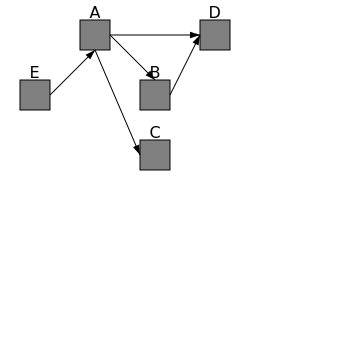

In [11]:

class SvgNodePortGraph:
    """
    draws nodes and edges to notebook using SVG
    nodes are just names and Positions
    edges are just Positions and Sides
    """
    
    # The spacing between the outermost nodes and the edge of the SVG drawing area
    margin = Dimension(20, 20)
    
    # distance from top-left corner to top-left corner
    spacing = Dimension(60, 60)
    
    # node size
    noded = Dimension(30, 30)
    
    # size of the svg drawing area
    svg_dims = Dimension(
        width=domain.width * spacing.width + 2 * margin.width,
        height=domain.height * spacing.height + 2 * margin.height)
    
    def _map_to_coords(self, pos):
        """ map logical coordinates to SVG coordinates """
        return Position(
            pos.x * self.spacing.width + self.margin.width,
            pos.y * self.spacing.height + self.margin.height)
    
    def __init__(self):
        self.svg = ET.Element(
            'svg',
            xmlns="http://www.w3.org/2000/svg",
            version="1.1",
            height="%s" % self.svg_dims.height,
            width="%s" % self.svg_dims.width)
        style = ET.SubElement(self.svg,"style")
        style.text = "rect {fill: gray; stroke: black;} line {stroke: black;}" 
        marker = ET.SubElement(
            self.svg,
            "marker",
            id="arrow",
            markerWidth="10",
            markerHeight="10",
            refX="9",
            refY="3",
            orient="auto",
            markerUnits="strokeWidth")
        ET.SubElement(marker, "path", d="M0,0 L0,6 L9,3 z")
        
    def drawbox(self, name, pos):
        """adds a new node to the graph"""
        npos = self._map_to_coords(pos)
        tpos = Position(npos.x + self.noded.width/2, npos.y - 2)
        ET.SubElement(
            self.svg,
            "rect",
            width=str(self.noded.width),
            height=str(self.noded.height),
            x=str(npos.x),
            y=str(npos.y))
        t = ET.SubElement(self.svg, "text", x=str(tpos.x), y=str(tpos.y))
        t.set("text-anchor","middle")
        t.text = name
    
    def _pos_adjust_side(self, pos, side):
        """ goes from a node position to a side position """
        adjustments = {
            Side.TOP:Position(self.noded.width/2, 0),
            Side.BOTTOM:Position(self.noded.width/2, self.noded.height),
            Side.LEFT:Position(0, self.noded.height/2),
            Side.RIGHT:Position(self.noded.width, self.noded.height/2)
        }
        a = adjustments[side]
        return Position(pos.x+ a.x, pos.y+a.y)
    
    def drawedge(self, source_pos, source_side, dest_pos, dest_side):
        """ adds a new edge to the graph """
        spos = self._pos_adjust_side(self._map_to_coords(source_pos), source_side)
        dpos = self._pos_adjust_side(self._map_to_coords(dest_pos), dest_side)
        l = ET.SubElement(
            self.svg,
            "line",
            x1=str(spos.x),
            x2=str(dpos.x),
            y1=str(spos.y),
            y2=str(dpos.y))
        l.set("marker-end","url(#arrow)")
    
    def display(self):
        """ displays the graph on the notebook """
        display(SVG(ET.tostring(self.svg)))

graph = SvgNodePortGraph()
for k,v in nodes.items():
    graph.drawbox(k,v['pos'])

for e in edges:
    sname = e['source_node']
    sside = nodes[sname]['ports'][e['source_port_index']]['side']
    source_pos = nodes[sname]['pos']
    dname = e['dest_node']
    dside = nodes[dname]['ports'][e['dest_port_index']]['side']
    dest_pos = nodes[dname]['pos']
    graph.drawedge(source_pos, sside, dest_pos, dside)
    
graph.display()